# <center>M1 : Physical oceanography</center>
 ## <center>Practical 1: Munk and Stommel models</center>
 #### <right>Pablo Fernandez Fernandez (pablo.fernandez@lmd.ipsl.fr) and Juliette Mignot (juliette.mignot@loean.ipsl.fr</right>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spoisson
#import xarray as xr
import matplotlib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
font = {'family' : 'Helvetica',
        'size'   : 22}

matplotlib.rc('font', **font)

### Definition of the characteristic variables of the system

In [3]:
#Characteristics of the bassin 
lat=30 #latitude in °
L=5000000 # in m
H=3000 #width in m
Vc=0.01 
T=L/Vc

#Constant
g=10 #gravitational constant in m/s^2
Rt = 6365000 #Earth's radius in m
f0 = 2*(2*np.pi/(24*3600))*np.sin(lat*np.pi/180) #Coriolis parameter in s^-1
#beta =  2*(2*np.pi/(24*3600))*np.cos(lat*np.pi/180) / Rt #Beta parameter

### Friction parameter for Munk and Stommel 

Change the variable *model* to 'Munk' or 'Stommel' to switch from one to the other.

In [4]:
models = ['Munk','Stommel']
model = 'Munk'

if model == 'Munk':
    print("You chose Munk's model.")
    epsilon_s =  0 # Stommel
    epsilon_m = 1e-5 # Munk
else : 
    if model != 'Stommel':
        print("Please choose either 'Munk' or 'Stommel' !")
    else :
        print("You chose Stommel's model.")
        epsilon_s =  1e-2 # Stommel
        epsilon_m = 0 # Munk
    

You chose Munk's model.


### Stream function

The stream function is solved by combining
$\beta v =  \frac{f}{H}\nabla \times \left( \frac{\tau}{\rho_0 f}\right) - r\zeta$ and
$\beta v =  \frac{f}{H}\nabla \times \left( \frac{\tau}{\rho_0 f}\right)  + A_h\nabla^2\zeta $ into a non-dimensional equation of the form $\frac{\partial \psi}{\partial x} =  \epsilon_S\nabla^2\psi - \epsilon_M\nabla^4 \psi = wnd $.

##### Compute a square grid to start (NxN)

In [5]:
N = 100
dx = 1/N
x = np.linspace(dx,1-dx,N)
y = np.linspace(dx,1-dx,N)
xx,yy = np.meshgrid(x,y)

##### Wind forcing

In [6]:
rhs = np.sin(np.pi*yy)

##### Friction term

Depends if *model* is 'Munk' or 'Stommel'.

In [7]:
A = spoisson.poisson2d(N)
A = epsilon_s*A/dx**2 - epsilon_m*A*A/dx**4

##### $\beta v$ term

In [8]:
B = A.tocsr()
for j in range(0,N):
  for i in range(1,N-1):
    k = i + N*j
    B[k,k+1] += 0.5/dx
    B[k,k-1] -= 0.5/dx
    
  # Boundaries
  k = N*j
  B[k,k+1]   += 0.5/dx
  k = N-1 + N*j
  B[k,k-1] -= 0.5/dx

##### Solving linear systerm and computing $\psi$

In [9]:
sol = - spoisson.sol(rhs, mat=B) #dimensionless
psi = sol*L*L/T #dimension added 
dX = dx * L #dimension added

##### Plot $\psi$

Text(0.5, 1.0, "Stream function $\\psi$ in Munk's model")

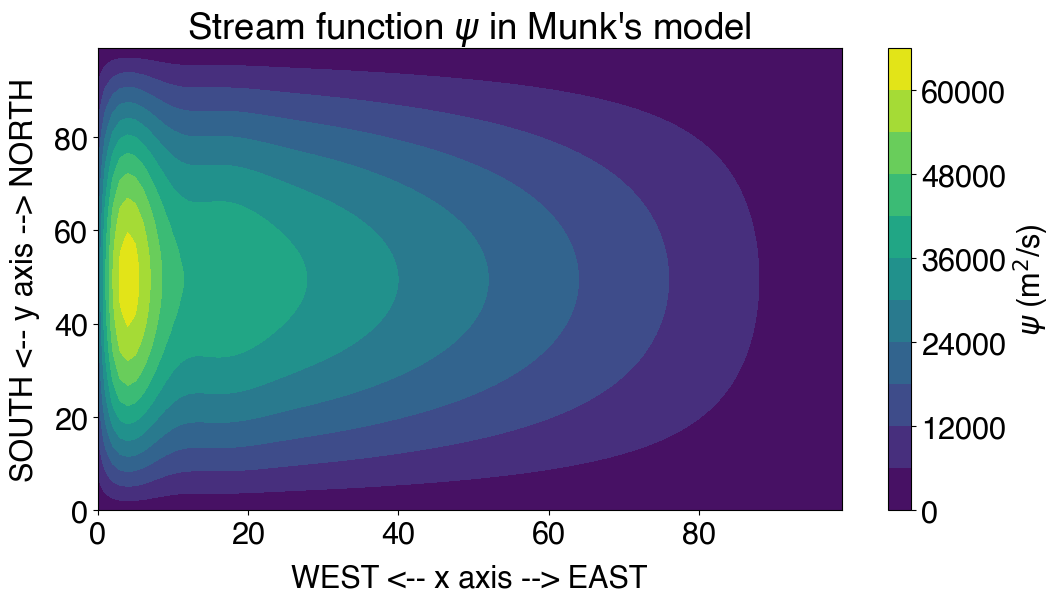

In [10]:
plt.figure(figsize=(12,6))
plt.contourf(psi,10)
plt.xlabel('WEST <-- x axis --> EAST',labelpad=10)
plt.ylabel('SOUTH <-- y axis --> NORTH',labelpad=10)
cb = plt.colorbar()
cb.ax.set_ylabel('$\psi$ (m$^2$/s)',rotation=90)
plt.title("Stream function $\psi$ in {}'s model".format(model))

##### Compute u, v, h and $\zeta$

Text(0.5, 1.0, "Meridional velocity in Munk's model")

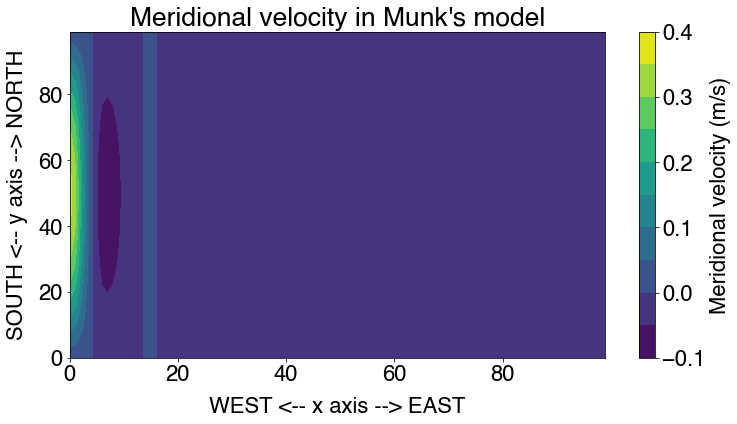

In [18]:
h = f0*psi/g
u = -np.gradient(psi)[0]/dX
v = np.gradient(psi)[1]/dX
zeta = np.gradient(v)[1]/dX #- np.gradient(u)[0]/dX


makeU=0
makeV=1
makeH=0
makeD=0

plt.figure(figsize=(12,6))
if makeU:
    plt.contourf(u,10)
    cb_label = 'Zonal velocity (m/s)'
    title = 'Zonal velocity'
elif makeV:
    plt.contourf(v,10)
    cb_label = 'Meridional velocity (m/s)'
    title = 'Meridional velocity'
elif makeH:
    plt.contourf(h,10)
    cb_label = 'Sea surface height (m)'
    title = 'Sea surface height'
elif makeD:
    plt.contourf(zeta,10)
    cb_label = 'Relative vorticity (s$^{-1}$)'
    title = 'Relative vorticity'
plt.xlabel('WEST <-- x axis --> EAST',labelpad=10)
plt.ylabel('SOUTH <-- y axis --> NORTH',labelpad=10)
cb = plt.colorbar()
cb.ax.set_ylabel(cb_label,rotation=90)
plt.title(title + " in {}'s model".format(model))

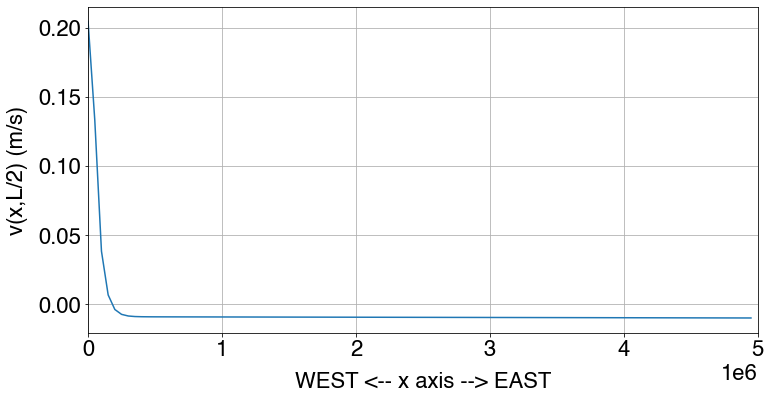

In [13]:
plt.figure(figsize=(12,6))
plt.plot(dX*np.arange(N),v[N//2,:])
plt.xlabel('WEST <-- x axis --> EAST',labelpad=10)
plt.ylabel('v(x,L/2) (m/s)',labelpad=10)
plt.xlim([0,L])
plt.grid()

In [13]:
S = H*dX
print('Transport in the subpolar gyre: ' + str(np.sum(v[3*N//4,:])*S/10**6) + ' Sv')
print('Transport in the subtropical gyre: ' + str(np.sum(v[N//4,:])*S/10**6) + ' Sv')

Transport in the subpolar gyre: -55.25026551041906 Sv
Transport in the subtropical gyre: -56.96797220509128 Sv


In [16]:
S = H*dX
i = np.where(v[N//2,:]<0)[0][0]
print('Transport in the western boundary current: ' + str(np.sum(v[N//2,:i])*S/10**6) + ' Sv')
print('Transport in the ocean interior: ' + str(np.sum(v[N//2,i:])*S/10**6) + ' Sv')

Transport in the western boundary current: 57.39674879223313 Sv
Transport in the ocean interior: -136.1257092314468 Sv
